# **Data Cleaning and Preprocessing For SAMSum**

### **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from datasets import load_dataset
nltk.download('punkt')
import re

e:\Final Year Project\Speech-to-Text Summarization System for Smart Note-Taking\Virtual\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Loading the Datasets**

In [3]:
dataset = load_dataset("knkarthick/samsum") # Loading SAMSum dataset
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

print("Train samples:", len(train))
print("Validation samples:", len(val))
print("Test samples:", len(test))
train[0]

Train samples: 14731
Validation samples: 818
Test samples: 819


{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

***Converting to Pandas DF***

In [4]:
train_df = pd.DataFrame(train)
val_df = pd.DataFrame(val)
test_df = pd.DataFrame(test)

train_df.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\nJ...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\nSam: i...,"Sam is confused, because he overheard Rick com..."


### **Basic EDA**

In [5]:
# Check nulls and duplicates
print(train_df.isnull().sum())
print("Duplicates:", train_df.duplicated().sum())

# Basic stats
print(train_df.describe(include='all'))

# Check dialogue and summary length
train_df["dialogue_len"] = train_df["dialogue"].apply(lambda x: len(x.split()))
train_df["summary_len"] = train_df["summary"].apply(lambda x: len(x.split()))

train_df[["dialogue_len", "summary_len"]].describe()

id          0
dialogue    0
summary     0
dtype: int64
Duplicates: 0
              id                                           dialogue  \
count      14731                                              14731   
unique     14731                                              14255   
top     13729017  Jimmy: Hey, guess what? My car's completely ka...   
freq           1                                                  4   

                               summary  
count                            14731  
unique                           14729  
top     Frank likes Macy's red outfit.  
freq                                 2  


,dialogue_len,summary_len
count,14731.000000,14731.000000
mean,93.792750,20.318444
std,74.031937,11.153570
min,7.000000,1.000000
25%,39.000000,12.000000
50%,73.000000,18.000000
75%,128.000000,27.000000
max,803.000000,64.000000


***Dialogue and Summary Lengths***

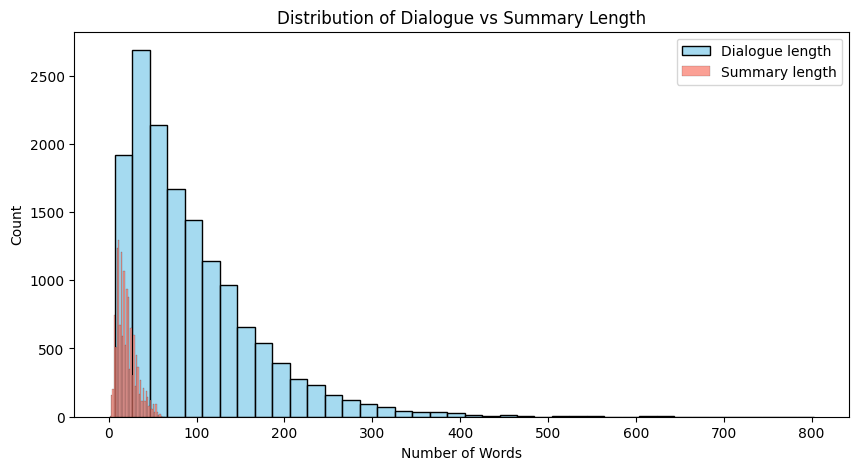

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(train_df["dialogue_len"], bins=40, color='skyblue', label='Dialogue length')
sns.histplot(train_df["summary_len"], bins=40, color='salmon', label='Summary length')
plt.legend()
plt.title("Distribution of Dialogue vs Summary Length")
plt.xlabel("Number of Words")
plt.show()

- Left-skewed

***World Cloud Visualization***

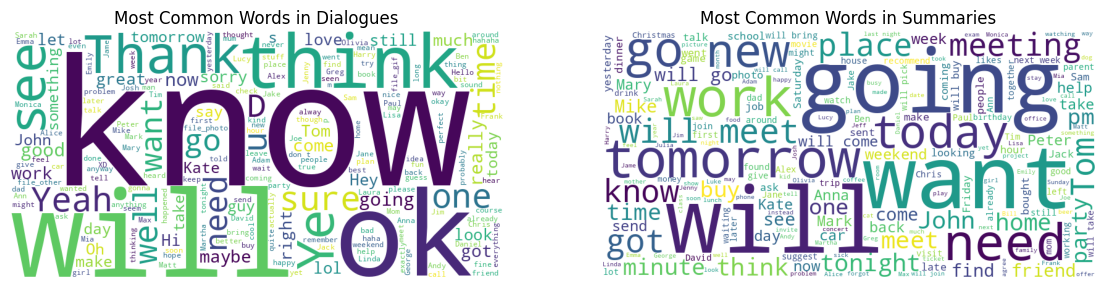

In [7]:
dialogue_text = " ".join(train_df["dialogue"])
summary_text = " ".join(train_df["summary"])

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(dialogue_text))
plt.title("Most Common Words in Dialogues")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(summary_text))
plt.title("Most Common Words in Summaries")
plt.axis("off")
plt.show()

### **Text Cleaning**

In [8]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"[^a-z0-9?.!,']+", " ", text)  # Remove special chars
    text = re.sub(r"\s+", " ", text).strip()  # Remove multiple spaces
    return text

train_df["clean_dialogue"] = train_df["dialogue"].apply(clean_text)
train_df["clean_summary"] = train_df["summary"].apply(clean_text)

train_df.head(2)

,id,dialogue,summary,dialogue_len,summary_len,clean_dialogue,clean_summary
0,13818513,Amanda: I baked cookies. Do you want some?\nJ...,Amanda baked cookies and will bring Jerry some...,16,9,amanda i baked cookies. do you want some? jerr...,amanda baked cookies and will bring jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,18,10,olivia who are you voting for in this election...,olivia and olivier are voting for liberals in ...


***Token count After cleaning***

In [9]:
train_df["clean_dialogue_len"] = train_df["clean_dialogue"].apply(lambda x: len(x.split()))
train_df["clean_summary_len"] = train_df["clean_summary"].apply(lambda x: len(x.split()))

print(train_df[["clean_dialogue_len", "clean_summary_len"]].describe())

       clean_dialogue_len  clean_summary_len
count        14731.000000       14731.000000
mean            93.730365          20.394814
std             74.119414          11.206904
min              6.000000           1.000000
25%             39.000000          12.000000
50%             73.000000          18.000000
75%            127.500000          27.000000
max            798.000000          64.000000


### **Removing Outliers**

In [10]:
max_dialogue_len = 512
filtered_df = train_df[train_df["clean_dialogue_len"] < max_dialogue_len]
print("Filtered data size:", len(filtered_df))

Filtered data size: 14713


### **Saving the Dataset**

In [11]:
filtered_df[["clean_dialogue", "clean_summary"]].to_csv("../data/clean/samsum/clean_samsum_train.csv", index=False)
val_df.to_csv("../data/clean/samsum/clean_samsum_val.csv", index=False)
test_df.to_csv("../data/clean/samsum/clean_samsum_test.csv", index=False)

print("Cleaned dataset saved at data/clean_samsum.csv")

Cleaned dataset saved at data/clean_samsum.csv


# **Conclusion**

***EDA Summary:***

    - The dataset contains ~14,000 dialogue-summary pairs.

    - Average dialogue length: ~90 words.

    - Average summary length: ~15 words.

    - Data is well-structured and mostly clean; minor normalization done.

    - After preprocessing, extreme outliers removed, leaving balanced input for model training.